# Building-level Energy Usage Correlation By Property Type over year

**Author:** Kiki Mei  
**Date:** November 2, 2025    
**Data Source:** Chicago Energy Benchmarking Dataset (2014-2023) - City of Chicago Open Data Portal  

## Section 1: Data Set up

In [6]:
# load in local helper functions
from utils.data_utils import clean_property_type, concurrent_buildings, load_data

In [75]:
import pandas as pd

# Load the data loader function
energy_data = load_data()

# Energy subset that includes only concurrent buildings appear across 2016-2023
energy_data = concurrent_buildings(energy_data, 2016, 2023)
energy_data = clean_property_type(energy_data)

print(
    f"Loaded dataset with {energy_data.shape[0]:,} rows and {energy_data.shape[1]} columns."
)
energy_data.head()

Loaded dataset with 18,904 rows and 30 columns.


,Data Year,ID,Property Name,Address,ZIP Code,Community Area,Primary Property Type,Gross Floor Area - Buildings (sq ft),Year Built,# of Buildings,...,Total GHG Emissions (Metric Tons CO2e),GHG Intensity (kg CO2e/sq ft),Latitude,Longitude,Location,Reporting Status,Chicago Energy Rating,Exempt From Chicago Energy Rating,Water Use (kGal),Row_ID
24486,2016,116336,lasalle private residences,1212 N LaSalle,60610,near north side,multifamily housing,367627.0,1986.0,1.0,...,2575.3,7.0,41.904201,-87.633825,point (-87.63382507 41.90420084),nan,NaN,nan,NaN,nan
24496,2016,101745,161 north clark,161 North Clark,60601,loop,office,1200836.0,1992.0,1.0,...,15498.4,12.9,41.884905,-87.630518,point (-87.6305179 41.88490511),nan,NaN,nan,NaN,nan
24495,2016,101448,1401 w roosevelt - 2017 resubmit,1401 W. Roosevelt,60608,near west side,multifamily housing,69385.0,2006.0,1.0,...,242.4,3.5,41.849153,-87.670896,point (-87.67089596 41.84915346),nan,NaN,nan,NaN,nan
24494,2016,159892,promontory corporation,5530-5532 S Shore Drive,60637,hyde park,multifamily housing,180351.0,1949.0,1.0,...,1317.3,7.3,41.794687,-87.580465,point (-87.58046479 41.794687),nan,NaN,nan,NaN,nan
24493,2016,103602,190 south lasalle,190 South LaSalle,60603,loop,office,882560.0,1985.0,1.0,...,11519.9,13.1,41.879756,-87.632687,point (-87.63268685 41.8797561),nan,NaN,nan,NaN,nan


Load in the refactored data_utils.py to load the energy dataset. The default dataset is the concurrent buildings after 2016.

In [76]:
energy_data = energy_data[
    energy_data["Primary Property Type"].notna()
    & (energy_data["Primary Property Type"].str.lower() != "nan")
]
print(energy_data.shape)

energy_data.groupby("Primary Property Type")["ID"].nunique().reset_index().sort_values(
    by="ID", ascending=False
).head(10)

(18760, 30)


,Primary Property Type,ID
23,multifamily housing,1169
15,k-12 school,379
27,office,313
3,college/university,75
13,hotel,67
46,senior care community,52
45,retail store,51
49,supermarket/grocery store,48
21,mixed use property,36
28,other,29


Check the composition of buildings in this time period. Most of them are multifamily housing.

## Section 2: Compute Consecutive-Year Deltas (Separate Charts)

Key question: If a building’s energy use decreases from year N to N+1, is it likely to continue decreasing from N+1 to N+2 (momentum), or to increase instead (reversal or random walk)?

To answer this question, we should focus on the correlation between the change of energy usage between year N to N+1 and year N+1 to N+2.

The years are divided into two groups: pre-2019, post-2019. As our default dataset is from 2016-2023 and the delta calculation makes the data for 2016 into null values, the years in pre-2019 includes [2017, 2018], the years in post-2019 includes [2019, 2020, 2021, 2022, 2023]. Each year in the group would be the value of N, each point in the graph represents a building posits by its delta from N to N+1 and N+1 to N+2, colored by the property type.

In [10]:
import altair as alt

In [15]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

Import the local helper function plot_energy_persistence_chart in utils/plot_utils.py to create the separate consecutive-year delta's correlation graph.

In [177]:
# load in local helper functions
from utils.plot_utils import plot_energy_persistence_by_year, plot_metric_by_property

Keep only the top 8 most common property types for visibility of graphs. Use Site EUI as the same example to apply the correlation tendency.

In [11]:
# Keep only top 8 most common property types overall
top_types = energy_data["Primary Property Type"].value_counts().nlargest(8).index

top_energy = energy_data[energy_data["Primary Property Type"].isin(top_types)].copy()
print(top_energy.shape)
top_energy.head()

cols = ["ID", "Data Year", "Primary Property Type", "Site EUI (kBtu/sq ft)"]
site_df = top_energy[cols].dropna().copy()

(16778, 30)


We will create dataframes of year-over-year deltas and the corresponding lagged year deltas to see the relationship between consecutive years.

In [12]:
site_df["Data Year"] = site_df["Data Year"].astype(int)
site_df["ID"] = site_df["ID"].astype(str)
site_df["Primary Property Type"] = site_df["Primary Property Type"].astype(str)
site_df["Site EUI (kBtu/sq ft)"] = pd.to_numeric(
    site_df["Site EUI (kBtu/sq ft)"], errors="coerce"
)
site_df = site_df.dropna(subset=["Site EUI (kBtu/sq ft)"])

df_delta = (
    site_df.sort_values(["ID", "Data Year"])
    .groupby("ID", group_keys=False)
    .apply(lambda g: g.assign(Delta=g["Site EUI (kBtu/sq ft)"].diff()))
    .dropna(subset=["Delta"])
    .reset_index(drop=True)
)

/tmp/ipykernel_36/3748790633.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.assign(Delta=g["Site EUI (kBtu/sq ft)"].diff()))


In [56]:
# Align delta_t and delta_t+1 for each building
df_lagged = (
    df_delta.sort_values(["Primary Property Type", "ID", "Data Year"])
    .groupby(["Primary Property Type", "ID"])
    .apply(
        lambda g: g.assign(
            Delta_next=g["Delta"].shift(-1)  # change from N+1→N+2
        )
    )
    .dropna(subset=["Delta", "Delta_next"])
    .reset_index(drop=True)
)

/tmp/ipykernel_36/1743661912.py:5: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(


In [55]:
df_lagged["N_year"] = df_lagged["Data Year"] - 1
df_lagged["N_year"].value_counts().sort_index()

N_year
2016    2072
2017    1997
2018    1505
2019    1861
2020    1701
2021    1686
Name: count, dtype: int64

The datapoints for 2022 and 2023 are missing because the correlation we are exploring draw the scatterplot and regression line with each point needs 3 consecutive data years — N, N+1, N+2. 

To draw a point for N = 2021, we need data through 2023.
To draw a point for N = 2022, we need data through 2024, which doesn’t exist in our dataset that ends at 2023.
So 2022 and 2023 have no valid Δₜ → Δₜ₊₁ pairs.

In [73]:
plot_energy_persistence_by_year(df_lagged)

alt.VConcatChart(...)

## Section 3: Year-over-year change of key metrics by COVID-influenced Type

To distinguish the effect of placards system from the effect of COVID, we would categorize building types affected by COVID into three groups: permanent effects (e.g. downtown office buildings), temporary effects that rebound in 2022/2023 (maybe schools), not much effect or even increased energy use (multifamily housing, hospitals).

First take a look at the composition and then grouped them. We will pick the top 30 categories as they appeared as necessary and includes most of the buildings in this dataset.

In [92]:
energy_data.groupby("Primary Property Type")["ID"].nunique().reset_index().sort_values(
    by="ID", ascending=False
)

,Primary Property Type,ID
23,multifamily housing,1169
15,k-12 school,379
27,office,313
3,college/university,75
13,hotel,67
46,senior care community,52
45,retail store,51
49,supermarket/grocery store,48
21,mixed use property,36
28,other,29


In [178]:
# load in local helper functions
from utils.data_utils import covid_impact_category

We will use the helper function assign_covid_impact_category in utils/data_utils.py to assign each property type into a corresponding impacted by COVID group.

In [149]:
energy_grouped = covid_impact_category(energy_data)
energy_grouped.head()

✅ COVID Impact Category assignment (with 'Other' group) complete:
COVID Impact Category
Other                    510
Permanent               2461
Stable/Increased       10217
Temporary/Rebounded     5572
Name: count, dtype: int64


,Data Year,ID,Property Name,Address,ZIP Code,Community Area,Primary Property Type,Gross Floor Area - Buildings (sq ft),Year Built,# of Buildings,...,GHG Intensity (kg CO2e/sq ft),Latitude,Longitude,Location,Reporting Status,Chicago Energy Rating,Exempt From Chicago Energy Rating,Water Use (kGal),Row_ID,COVID Impact Category
24486,2016,116336,lasalle private residences,1212 N LaSalle,60610,near north side,multifamily housing,367627.0,1986.0,1.0,...,7.0,41.904201,-87.633825,point (-87.63382507 41.90420084),nan,NaN,nan,NaN,nan,Stable/Increased
24496,2016,101745,161 north clark,161 North Clark,60601,loop,office,1200836.0,1992.0,1.0,...,12.9,41.884905,-87.630518,point (-87.6305179 41.88490511),nan,NaN,nan,NaN,nan,Permanent
24495,2016,101448,1401 w roosevelt - 2017 resubmit,1401 W. Roosevelt,60608,near west side,multifamily housing,69385.0,2006.0,1.0,...,3.5,41.849153,-87.670896,point (-87.67089596 41.84915346),nan,NaN,nan,NaN,nan,Stable/Increased
24494,2016,159892,promontory corporation,5530-5532 S Shore Drive,60637,hyde park,multifamily housing,180351.0,1949.0,1.0,...,7.3,41.794687,-87.580465,point (-87.58046479 41.794687),nan,NaN,nan,NaN,nan,Stable/Increased
24493,2016,103602,190 south lasalle,190 South LaSalle,60603,loop,office,882560.0,1985.0,1.0,...,13.1,41.879756,-87.632687,point (-87.63268685 41.8797561),nan,NaN,nan,NaN,nan,Permanent


In [150]:
energy_grouped.groupby(["Primary Property Type", "COVID Impact Category"])[
    "ID"
].nunique().reset_index().sort_values(by="ID", ascending=False).head(15)

,Primary Property Type,COVID Impact Category,ID
23,multifamily housing,Stable/Increased,1169
15,k-12 school,Temporary/Rebounded,379
27,office,Permanent,313
3,college/university,Temporary/Rebounded,75
13,hotel,Temporary/Rebounded,67
46,senior care community,Stable/Increased,52
45,retail store,Temporary/Rebounded,51
49,supermarket/grocery store,Temporary/Rebounded,48
21,mixed use property,Other,36
28,other,Other,29


In [153]:
covid_site = plot_metric_by_property(
    df=energy_grouped,
    metric_col="Site EUI (kBtu/sq ft)",
    property_col="COVID Impact Category",
    agg_func=pd.Series.median,
)
covid_site

alt.LayerChart(...)

In [152]:
covid_elec = plot_metric_by_property(
    df=energy_grouped,
    metric_col="Electricity Use (kBtu)",
    property_col="COVID Impact Category",
    agg_func=pd.Series.median,
)
covid_elec

alt.LayerChart(...)

The tendency of each group shows the similar pattern as their expected influenced level by COVID. Buildings that are permanently affected such as offices and commercial properties because of the decline employee occupation display a critical decrease in electricity use after 2019, though rebound a little bit in 2022, the total level keeps low. Buildings temporary influenced by COVID such as schools and supermarket show a sharp decrease in 2020, but then the level of energy use rebound back to the normal level. Buildings that should be stable and even increased usage of energy such as multifamily housing or hospital show a little fluctuated energy use, but the total tendency remains unchanged.

## Section 4: Metrics pattern for the overall decrease in energy usage from 2022 to 2023

Too closely see the declining trend in 2023, we could filter the dataset into rows only containing data from 2022 to 2023, and explore the energy usage of different key metrics.

In [ ]:
year_2022 = 2022
energy_2023 = energy_grouped[energy_grouped["Data Year"] >= year_2022].copy()
print(energy_2023.shape)
energy_2023.head()

(4671, 31)


,Data Year,ID,Property Name,Address,ZIP Code,Community Area,Primary Property Type,Gross Floor Area - Buildings (sq ft),Year Built,# of Buildings,...,GHG Intensity (kg CO2e/sq ft),Latitude,Longitude,Location,Reporting Status,Chicago Energy Rating,Exempt From Chicago Energy Rating,Water Use (kGal),Row_ID,COVID Impact Category
14756,2022,250062,rj quinn academy,558 W De Koven St,60607,near west side,adult education,66285.0,1961.0,1.0,...,7.9,41.869117,-87.641350,point (-87.64134962810887 41.869117307784904),submitted data,2.0,false,NaN,2022-250062,Temporary/Rebounded
14754,2022,101742,james r thompson center,100 W Randolph St,60601,loop,office,1193163.0,NaN,NaN,...,NaN,41.884586,-87.631010,point (-87.63101044588599 41.88458626715456),not submitted,0.0,false,NaN,2022-101742,Permanent
14752,2022,100856,united center,1901 W Madison St,60612,near west side,indoor arena,2289000.0,NaN,NaN,...,NaN,41.881241,-87.674283,point (-87.67428253395332 41.881241456803345),not submitted,0.0,false,NaN,2022-100856,Temporary/Rebounded
14757,2022,101545,nan,849 863 W BUENA AVE,60613,uptown,multifamily housing,51163.0,1925.0,1.0,...,5.9,41.958353,-87.651806,point (-87.65180597369445 41.95835278315766),submitted data,2.0,false,NaN,2022-101545,Stable/Increased
14759,2022,157280,noble square cooperative,1165 N MILWAUKEE AVE,60642,west town,multifamily housing,284850.0,1969.0,1.0,...,6.7,41.903005,-87.665707,point (-87.66570654445466 41.903005039235026),submitted data,2.5,false,NaN,2022-157280,Stable/Increased


First do statistical analysis to see whether there's a significant dip in 2023.

In [158]:
metrics = [
    "Site EUI (kBtu/sq ft)",
    "Weather Normalized Site EUI (kBtu/sq ft)",
    "Source EUI (kBtu/sq ft)",
    "Weather Normalized Source EUI (kBtu/sq ft)",
    "Electricity Use (kBtu)",
    "Natural Gas Use (kBtu)",
    "GHG Intensity (kg CO2e/sq ft)",
]

df_summary = (
    energy_data.groupby("Data Year")[metrics]
    .median()  # or mean
    .diff()  # year-over-year change
    .rename(lambda c: f"Δ {c}", axis=1)
)
df_summary.loc[2023]

Δ Site EUI (kBtu/sq ft)                             -7.20
Δ Weather Normalized Site EUI (kBtu/sq ft)          -1.80
Δ Source EUI (kBtu/sq ft)                          -11.00
Δ Weather Normalized Source EUI (kBtu/sq ft)        -3.85
Δ Electricity Use (kBtu)                       -237404.20
Δ Natural Gas Use (kBtu)                       -348687.55
Δ GHG Intensity (kg CO2e/sq ft)                     -0.40
Name: 2023, dtype: float64

In [162]:
delta_by_type = energy_data.pivot_table(
    index="Primary Property Type",
    columns="Data Year",
    values="Site EUI (kBtu/sq ft)",
    aggfunc="median",
)
delta_by_type["Δ2023"] = delta_by_type[2023] - delta_by_type[2022]
delta_by_type.sort_values("Δ2023")

Data Year,2016,2017,2018,2019,2020,2021,2022,2023,Δ2023
Primary Property Type,,,,,,,,,
fitness center/health club/gym,185.35,185.25,178.65,230.80,135.70,157.10,199.10,139.30,-59.80
movie theater,159.95,151.00,148.10,124.90,125.00,131.60,163.70,132.25,-31.45
social/meeting hall,130.65,77.50,81.60,74.45,87.90,103.20,177.25,149.60,-27.65
other - mall,93.40,88.50,78.90,105.20,81.50,81.60,108.30,81.70,-26.60
other - recreation,114.70,124.20,139.50,83.05,74.65,58.45,73.10,49.50,-23.60
medical office,117.50,124.90,116.60,115.75,108.20,105.40,117.55,97.95,-19.60
library,113.50,92.70,95.90,111.60,96.75,102.50,122.80,104.00,-18.80
adult education,96.10,143.80,117.30,127.20,124.05,127.80,132.90,117.80,-15.10
outpatient rehabilitation/physical therapy,87.10,94.40,115.80,125.40,103.00,115.70,106.90,94.50,-12.40


Then see the visualization of energy key metrics and the property type, analyze how different buildings may contribute to this decrease in energy use.

In [139]:
import matplotlib.pyplot as plt

metrics = [
    "Site EUI (kBtu/sq ft)",
    "Weather Normalized Site EUI (kBtu/sq ft)",
    "Source EUI (kBtu/sq ft)",
    "Weather Normalized Source EUI (kBtu/sq ft)",
]

trend_df = energy_2023.groupby("Data Year")[metrics].median()

To show the trend, we should explore the main key metrics of energy performance. To see whether the weather influences energy usage in 2023, we could compare the trend of site eui/source eui with the weather normalized site eui/source eui.

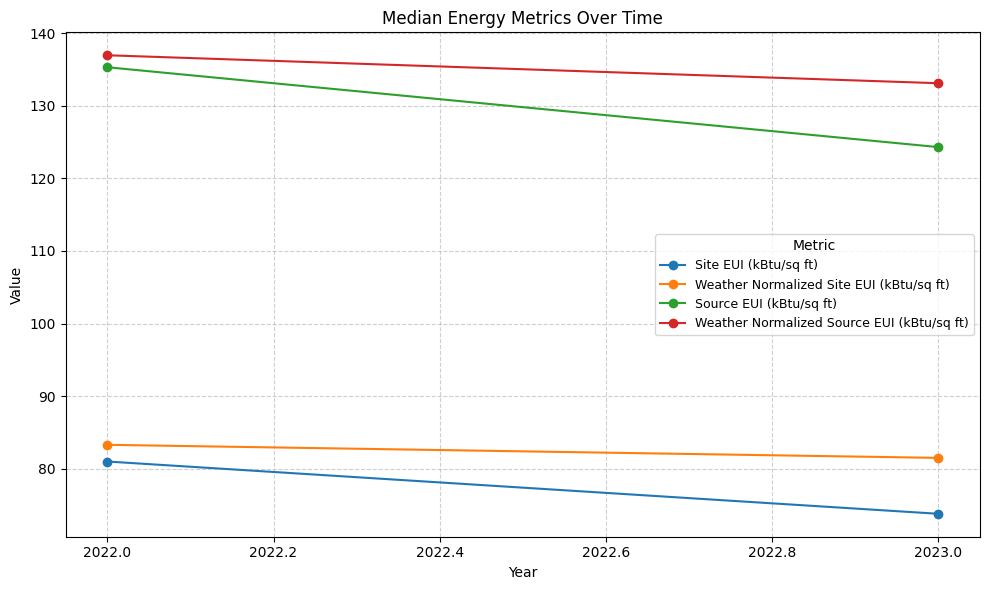

In [140]:
plt.figure(figsize=(10, 6))

for col in metrics:
    if col in trend_df.columns:
        plt.plot(trend_df.index, trend_df[col], marker="o", linestyle="-", label=col)

plt.title("Median Energy Metrics Over Time")
plt.xlabel("Year")
plt.ylabel("Value")
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(title="Metric", fontsize=9)
plt.tight_layout()
plt.show()

Because the weather-normalized metrics show little or no change while the unadjusted metrics decrease, the 2023 energy reduction likely reflects milder weather conditions rather than major shifts in building efficiency or behavior.

In [171]:
# Keep only top 8 most common property types overall
top_types = energy_2023["Primary Property Type"].value_counts().nlargest(10).index

top_energy = energy_2023[energy_2023["Primary Property Type"].isin(top_types)].copy()
print(top_energy.shape)
top_energy.head()

median_site = plot_metric_by_property(
    df=top_energy, metric_col="Site EUI (kBtu/sq ft)", agg_func=pd.Series.median
)
median_site

(4255, 31)


alt.LayerChart(...)

In [175]:
median_source = plot_metric_by_property(
    df=top_energy,
    metric_col="Weather Normalized Site EUI (kBtu/sq ft)",
    agg_func=pd.Series.median,
)
median_source

alt.LayerChart(...)

In [ ]:
covid_site = plot_metric_by_property(
    df=top_energy,
    metric_col="Site EUI (kBtu/sq ft)",
    property_col="COVID Impact Category",
    agg_func=pd.Series.median,
)
covid_site

alt.LayerChart(...)

In [176]:
covid_weather_site = plot_metric_by_property(
    df=top_energy,
    metric_col="Weather Normalized Site EUI (kBtu/sq ft)",
    property_col="COVID Impact Category",
    agg_func=pd.Series.median,
)
covid_weather_site

alt.LayerChart(...)

Across most property types, median Site EUI (kBtu/sq ft) declined modestly from 2022 to 2023, suggesting an overall reduction in on-site energy use. However, the weather-normalized Site EUI shows far smaller changes, indicating that much of the apparent decrease was likely driven by milder weather conditions rather than true improvements in operational efficiency. In other words, buildings used less energy primarily because heating and cooling demand eased in 2023, not necessarily because their underlying energy performance or management practices changed significantly.

However, this rough data exploration only rejects the null hypothesis of "weather doesn't have any effect on the energy usage", but it doesn't necessarily supports that weather is the only factor that influences the energy usage in this dataset and context. It could be the influence of other events happening in 2023 that results in a dip in energy. These include continued hybrid work patterns and reduced building occupancy after COVID-19, rising energy costs prompting conservation, gradual efficiency improvements from retrofit programs and smart building technologies, and behavioral responses to public energy ratings. 

Together, these structural, economic, and policy-driven dynamics may have compounded to lower overall energy intensity across property types.